**Proyek Klasifikasi Gambar: A Large Scale Fish Dataset**

*   Nama : Arif Kurniawan
*   Email: mc299d5y1908@student.devacademy.id
*   ID Dicoding: MC299D5Y1908



# **Import Libraries**

In [ ]:
# Mengimpor libraries umum yang sering digunakan
import os, shutil
import zipfile
import random
from random import sample
import shutil
from shutil import copyfile
import pathlib
from pathlib import Path
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm as tq

# Mengimpor libraries untuk visualisasi
%matplotlib inline
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.image import imread

# Mengimpor libraries untuk pemrosesan data gambar
import cv2
from PIL import Image
import skimage
from skimage import io
from skimage.transform import resize
from skimage.transform import rotate, AffineTransform, warp
from skimage import img_as_ubyte
from skimage.exposure import adjust_gamma
from skimage.util import random_noise

# Mengimpor libraries untuk pembuatan dan evaluasi model
import keras
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import tensorflow as tf
from tensorflow.keras import Model, layers
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from tensorflow.keras.layers import InputLayer, Conv2D, SeparableConv2D, MaxPooling2D, MaxPool2D, Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.applications.densenet import DenseNet121
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint, Callback, EarlyStopping, ReduceLROnPlateau

# Mengabaikan peringatan
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [ ]:
# Mencetak versi TensorFlow yang sedang digunakan
print(tf.__version__)

2.18.0


# **Data Loading**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
!pip install gdown


In [ ]:
import gdown

file_id = '18ERDQ0NtU_nvSqKEMN99I-EKrcDHvmwQ'
url = f'https://drive.google.com/uc?id={file_id}'
gdown.download(url, output='dataset.zip', quiet=False)


Downloading...
From (original): https://drive.google.com/uc?id=18ERDQ0NtU_nvSqKEMN99I-EKrcDHvmwQ
From (redirected): https://drive.google.com/uc?id=18ERDQ0NtU_nvSqKEMN99I-EKrcDHvmwQ&confirm=t&uuid=c1236069-ed98-4036-bdb4-9cde52ba922e
To: /content/dataset.zip
100%|██████████| 3.48G/3.48G [00:45<00:00, 76.8MB/s]


'dataset.zip'

In [ ]:
# Ekstrak file zip
import zipfile

with zipfile.ZipFile('dataset.zip', 'r') as zip_ref:
    zip_ref.extractall('dataset')


In [ ]:
# Cek nama kelas
import os

dataset_path = 'dataset'
class_names = os.listdir(dataset_path)
print("Kelas yang ditemukan:", class_names)

Kelas yang ditemukan: ['Fish_Dataset', 'NA_Fish_Dataset', 'README.txt', 'license.txt', 'Segmentation_example_script.m']


In [ ]:


def print_directory_tree(startpath):
    for root, dirs, files in os.walk(startpath):
        level = root.replace(startpath, '').count(os.sep)
        indent = ' ' * 4 * level
        print(f"{indent}{os.path.basename(root)}/")
        subindent = ' ' * 4 * (level + 1)
        for f in files[:5]:  # tampilkan max 5 file per folder
            print(f"{subindent}{f}")

print_directory_tree("dataset/Fish_Dataset")

Fish_Dataset/
    Fish_Dataset/
        README.txt
        license.txt
        Segmentation_example_script.m
        Black Sea Sprat/
            Black Sea Sprat/
                00683.png
                00623.png
                00678.png
                00124.png
                00735.png
            Black Sea Sprat GT/
                00683.png
                00623.png
                00678.png
                00124.png
                00735.png
        Shrimp/
            Shrimp/
                00683.png
                00623.png
                00678.png
                00124.png
                00735.png
            Shrimp GT/
                00683.png
                00623.png
                00678.png
                00124.png
                00735.png
        Sea Bass/
            Sea Bass/
                00683.png
                00623.png
                00678.png
                00124.png
                00735.png
            Sea Bass GT/
                00683.png
     

# . Data Preprocessing & Split Dataset

In [ ]:
original_dataset_dir = Path("dataset/Fish_Dataset/Fish_Dataset") # Sesuaikan dengan lokasi ekstraksi zip
split_base_dir = Path("Fish_Dataset_Split")

# Persentase pembagian
split_ratio = {'train': 0.8, 'val': 0.1, 'test': 0.1}

# Hapus folder sebelumnya jika ada
if split_base_dir.exists():
    shutil.rmtree(split_base_dir)
split_base_dir.mkdir(parents=True)

# Proses pembagian
for class_dir in os.listdir(original_dataset_dir):
    class_path = original_dataset_dir / class_dir / class_dir
    if not class_path.is_dir():
        continue

    images = list(class_path.glob("*.png"))
    random.shuffle(images)

    n = len(images)
    n_train = int(split_ratio['train'] * n)
    n_val = int(split_ratio['val'] * n)

    splits = {
        'train': images[:n_train],
        'val': images[n_train:n_train + n_val],
        'test': images[n_train + n_val:]
    }

    for split_name, split_images in splits.items():
        split_class_dir = split_base_dir / split_name / class_dir
        split_class_dir.mkdir(parents=True, exist_ok=True)
        for img_path in split_images:
            shutil.copy(img_path, split_class_dir / img_path.name)

print("✅ Dataset berhasil dibagi menjadi train/val/test.")

✅ Dataset berhasil dibagi menjadi train/val/test.


In [ ]:
img_size = (180, 180)
batch_size = 32

train_ds = tf.keras.utils.image_dataset_from_directory(
    "Fish_Dataset_Split/train",
    image_size=img_size,
    batch_size=batch_size,
    label_mode='categorical'
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    "Fish_Dataset_Split/val",
    image_size=img_size,
    batch_size=batch_size,
    label_mode='categorical'
)

test_ds = tf.keras.utils.image_dataset_from_directory(
    "Fish_Dataset_Split/test",
    image_size=img_size,
    batch_size=batch_size,
    label_mode='categorical'
)
# Ambil nama kelas dan jumlah kelas
class_names = train_ds.class_names
num_classes = len(class_names)

print(" Daftar kelas:", class_names)
print(" Jumlah kelas:", num_classes)


Found 7200 files belonging to 9 classes.
Found 900 files belonging to 9 classes.
Found 900 files belonging to 9 classes.
 Daftar kelas: ['Black Sea Sprat', 'Gilt-Head Bream', 'Hourse Mackerel', 'Red Mullet', 'Red Sea Bream', 'Sea Bass', 'Shrimp', 'Striped Red Mullet', 'Trout']
 Jumlah kelas: 9


# Modelling

In [ ]:
from tensorflow.keras import layers, models

# Model CNN Sederhana tapi kuat
model = models.Sequential([
    layers.Rescaling(1./255, input_shape=(180, 180, 3)),  # Normalisasi dan definisi input
    layers.Conv2D(32, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(128, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(num_classes, activation='softmax')  # output layer untuk multiclass
])

# Kompilasi model
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy', # Changed from sparse_categorical_crossentropy
    metrics=['accuracy']
)

# Tampilkan struktur model
model.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling_1 (Rescaling)         │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 178, 178, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 89, 89, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 87, 87, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 43, 43, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 41, 41, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 20, 20, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 51200)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │     6,553,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 9)              │         1,161 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,648,137 (25.36 MB)

 Trainable params: 6,648,137 (25.36 MB)

 Non-trainable params: 0 (0.00 B)

# Evaluasi dan Visualisasi

In [ ]:
# Training
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=5
)


Epoch 1/5
225/225 ━━━━━━━━━━━━━━━━━━━━ 567s 3s/step - accuracy: 0.4756 - loss: 1.4464 - val_accuracy: 0.7689 - val_loss: 0.6360
Epoch 2/5
225/225 ━━━━━━━━━━━━━━━━━━━━ 576s 3s/step - accuracy: 0.8983 - loss: 0.3044 - val_accuracy: 0.9289 - val_loss: 0.2195
Epoch 3/5
225/225 ━━━━━━━━━━━━━━━━━━━━ 619s 3s/step - accuracy: 0.9652 - loss: 0.1086 - val_accuracy: 0.9622 - val_loss: 0.0995
Epoch 4/5
225/225 ━━━━━━━━━━━━━━━━━━━━ 606s 2s/step - accuracy: 0.9870 - loss: 0.0425 - val_accuracy: 0.9456 - val_loss: 0.1517
Epoch 5/5
225/225 ━━━━━━━━━━━━━━━━━━━━ 576s 3s/step - accuracy: 0.9879 - loss: 0.0386 - val_accuracy: 0.9744 - val_loss: 0.0907


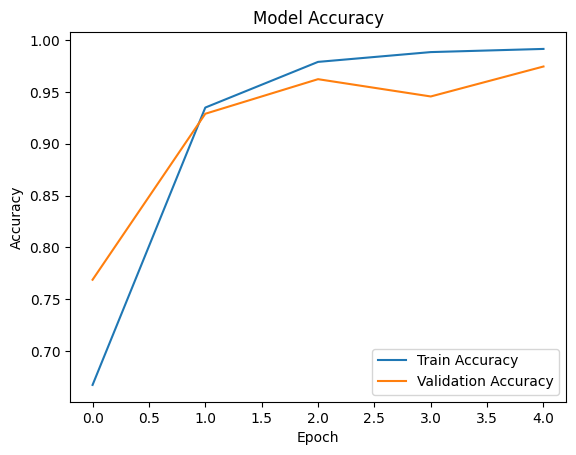

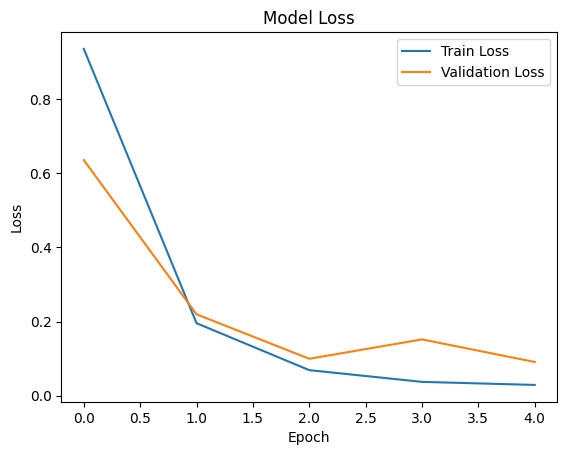

In [ ]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [ ]:
# Akurasi train dan test
train_loss, train_acc = model.evaluate(train_ds, verbose=1)
test_loss, test_acc = model.evaluate(test_ds, verbose=1)
print(f"\nTraining accuracy: {train_acc*100:.2f}%")
print(f"\nTesting accuracy: {test_acc*100:.2f}%")

225/225 ━━━━━━━━━━━━━━━━━━━━ 191s 848ms/step - accuracy: 0.9955 - loss: 0.0122
29/29 ━━━━━━━━━━━━━━━━━━━━ 25s 834ms/step - accuracy: 0.9781 - loss: 0.0533

Training accuracy: 99.68%

Testing accuracy: 97.78%


In [ ]:

val_loss, val_acc = model.evaluate(val_ds)

print(f"\n Akurasi Validasi: {val_acc*100:.2f}%")


29/29 ━━━━━━━━━━━━━━━━━━━━ 24s 788ms/step - accuracy: 0.9692 - loss: 0.1081

 Akurasi Validasi: 97.44%


###**Membuat Folder pada Drive untuk menyimpan save_model, tflite dan tfjs**

In [ ]:
from google.colab import drive
import os
import shutil

mountpoint = '/content/Drive'

# Check if the mountpoint directory exists and is not empty
if os.path.exists(mountpoint) and os.path.isdir(mountpoint):
    if os.listdir(mountpoint):
        print(f"Mountpoint '{mountpoint}' is not empty. Removing contents...")
        try:
            shutil.rmtree(mountpoint)
            print(f"Contents of '{mountpoint}' removed.")
        except Exception as e:
            print(f"Error removing contents of '{mountpoint}': {e}")
            # Consider whether to continue or raise an error here

# Recreate the mountpoint directory if it doesn't exist or was removed
if not os.path.exists(mountpoint):
    os.makedirs(mountpoint)
    print(f"Mountpoint directory '{mountpoint}' created.")


# Attempt to mount Google Drive
print(f"Attempting to mount Google Drive to '{mountpoint}'...")
drive.mount(mountpoint)
print("Google Drive mounted successfully.")

Mountpoint '/content/Drive' is not empty. Removing contents...
Contents of '/content/Drive' removed.
Mountpoint directory '/content/Drive' created.
Attempting to mount Google Drive to '/content/Drive'...
Mounted at /content/Drive
Google Drive mounted successfully.


In [ ]:
model.export('/content/Drive/MyDrive/Poster/saved_model')


Saved artifact at '/content/Drive/MyDrive/Poster/saved_model'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 180, 180, 3), dtype=tf.float32, name='keras_tensor_11')
Output Type:
  TensorSpec(shape=(None, 9), dtype=tf.float32, name=None)
Captures:
  140004261169488: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140004261170064: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140004261170640: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140004261171216: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140004261170448: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140004261171984: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140004261171408: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140004261172752: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140004261172176: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140004261173520: TensorSpec(shape=(), dtype=tf.resource,

In [ ]:

# Konversi ke TFLite
converter = tf.lite.TFLiteConverter.from_saved_model('/content/Drive/MyDrive/Poster/saved_model')
tflite_model = converter.convert()

# Simpan file .tflite ke Drive
with open('/content/Drive/MyDrive/Poster/model.tflite', 'wb') as f:
    f.write(tflite_model)
# Buat direktori baru jika belum ada
tflite_dir = '/content/Drive/MyDrive/Poster/tflite'
if not os.path.exists(tflite_dir):
    os.mkdir(tflite_dir)

with open(os.path.join(tflite_dir, 'model.tflite'), 'wb') as f:
  f.write(tflite_model)

# Simpan label
# Access class names directly from the dataset object
class_names = train_ds.class_names
with open(os.path.join(tflite_dir, 'labels.txt'), "w") as f:
    f.write("\n".join(class_names))

In [ ]:
# Convert model kedalam tensorflow.js
!pip install tensorflowjs

import tensorflowjs as tfjs # Import the tensorflowjs library

model.save('tfjs_model.h5')

# Convert ke TensorFlow.js format
tfjs.converters.save_keras_model(model, '/content/Drive/MyDrive/Poster/tfjs')

failed to lookup keras version from the file,
    this is likely a weight only file


# Inference

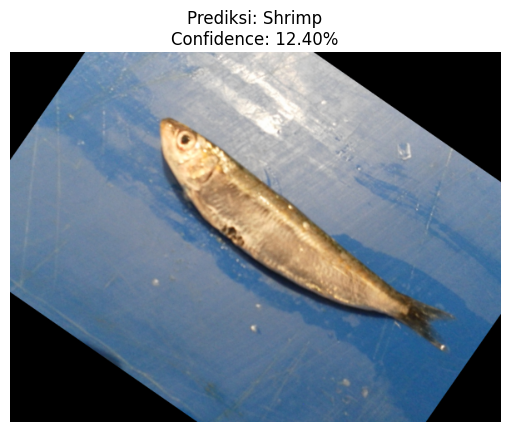

In [ ]:
# Path ke gambar uji
img_path = 'dataset/Fish_Dataset/Fish_Dataset/Black Sea Sprat/Black Sea Sprat/00002.png'

try:
    # Load dan preprocess gambar
    img = Image.open(img_path).convert('RGB')
    img_resized = img.resize((180, 180))
    img_array = np.array(img_resized, dtype=np.float32) / 255.0
    img_array = np.expand_dims(img_array, axis=0)  # shape (1, 180, 180, 3)

    # Load model TFLite
    interpreter = tf.lite.Interpreter(model_path="/content/Drive/MyDrive/Poster/model.tflite")
    interpreter.allocate_tensors()

    input_index = interpreter.get_input_details()[0]['index']
    output_index = interpreter.get_output_details()[0]['index']

    # Inferensi
    interpreter.set_tensor(input_index, img_array)
    interpreter.invoke()
    output = interpreter.get_tensor(output_index)

    # Ambil prediksi dan confidence
    predicted_class_index = np.argmax(output)
    confidence = np.max(output) * 100

    # Ambil nama kelas
    if 'class_names' in globals() and predicted_class_index < len(class_names):
        predicted_class = class_names[predicted_class_index]
    else:
        predicted_class = f"Kelas tidak diketahui (Index: {predicted_class_index})"
        if 'class_names' not in globals():
            print("Warning: 'class_names' belum didefinisikan. Pastikan cell sebelumnya sudah dijalankan.")

    # Tampilkan hasil
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"Prediksi: {predicted_class}\nConfidence: {confidence:.2f}%", fontsize=12)
    plt.show()

except FileNotFoundError:
    print(f" Error: Gambar tidak ditemukan di path {img_path}.")
except Exception as e:
    print(f" Terjadi kesalahan saat inferensi: {e}")

In [ ]:
!pip freeze > requirements.txt


In [ ]:
from google.colab import files
files.download('requirements.txt')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>